In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# variable definitions
datasetArray = [] # array to store all the datasets in to enable randomization
visualiseDataSets = False # option to stop printing all visualisations when loading in a new dataset

Loading data into a dataframe from excel sheets

In [2]:
def create_df_from_sheet(sheet: str) -> pd.DataFrame:
    df = pd.read_excel("./all data(from manon).xlsx", sheet_name=sheet)
    df.columns = df.iloc[1]
    df = df.iloc[2:]
    if len(df.columns) > 4:
        df.drop(columns=df.columns[-2:], axis=1, inplace=True)
    df.columns = ["timestamp", "no_units", "RangeCAL_uS", "SkinResistanceCAL_kOhms"]
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d %H:%M:%S.%f') # change the string formatted times to pandas datetime
    df['timestamp'] = df.timestamp-df.timestamp[2] # convert the time to relative from the start of the measurements
    datasetArray.append(df)
    return df


Plotting the data from the dataframe

In [3]:
def plot_df(df: pd.DataFrame):
    if visualiseDataSets:
        df.iloc[:, [0, 1]].plot(x='timestamp', ylim=[0,3.1],xlabel='Time', ylabel='Calibration mode', rot=45)
        df.iloc[:, [0, 2]].plot(x='timestamp', xlabel='Time', ylabel='Galvanic skin response', rot=45)
        df.iloc[:, [0, 3]].plot(x='timestamp', xlabel='Time', ylabel='Skin resistance', rot=45)


# Loading data
Here we load the data from the excel sheets and plot it to give a general idea of what the data looks like

In [4]:
test612_2 = create_df_from_sheet("612_2")
plot_df(test612_2)

## Efficiency
Cells below are commented out to speed up the runtime and not load in unused datasets.

These can be uncommented as needed.

In [5]:
# test612_3 = create_df_from_sheet("612_3")
# plot_df(test612_3)

In [6]:
# test612_4 = create_df_from_sheet("612_4")
# plot_df(test612_4)

In [7]:
## BAD DATA SET
# lots of noise and no clear correlation with the tests that occurred.
# test612_5 = create_df_from_sheet("612_5")
# plot_df(test612_5)

In [8]:
# test612_6 = create_df_from_sheet("612_6")
# plot_df(test612_6)

In [9]:
# test612_7 = create_df_from_sheet("612_7")
# plot_df(test612_7)

In [10]:
# test712_1 = create_df_from_sheet("712_1")
# plot_df(test712_1)

In [11]:
# test712_2 = create_df_from_sheet("712_2")
# plot_df(test712_2)

In [12]:
# test712_3 = create_df_from_sheet("712_3")
# plot_df(test712_3)

In [13]:
# test712_4 = create_df_from_sheet("712_4")
# plot_df(test712_4)

In [14]:
# test712_5 = create_df_from_sheet("712_5")
# plot_df(test712_5)

In [15]:
# test712_6 = create_df_from_sheet("712_6")
# plot_df(test712_6)

In [16]:
# test712_7 = create_df_from_sheet("712_7")
# plot_df(test712_7)

In [17]:
# test712_8 = create_df_from_sheet("712_8")
# plot_df(test712_8)

# randomized datasets start here
Run cells below again with "random_dataset = True" to get a random dataset which was loaded in with the "create_df_from_sheet" function. If not set to true, it is possible to manually change the dataset.

In [18]:
from sklearn.preprocessing import MinMaxScaler
random_dataset = False

scaler = MinMaxScaler()
dfTemp= datasetArray[0]

if(random_dataset):
    dfTemp =  np.random.choice(datasetArray)
    print(type(dfTemp))

dfTemp['RangeCAL_uS'] = scaler.fit_transform(dfTemp[['RangeCAL_uS']])

# df1_1 = dfTemp.iloc[:, [0, 1]] # calibration value, unused
df1_2 = dfTemp.iloc[:, [0, 2]] # primary sensor values
# df1_3 = dfTemp.iloc[:, [0, 3]] # secondary sensor with basically the same values as the first, but with inverted values. unused.
df1_2 # show the data we're working with

,timestamp,RangeCAL_uS
2,0 days 00:00:00,0.086775
3,0 days 00:00:00.250000,0.086822
4,0 days 00:00:00.500000,0.086965
5,0 days 00:00:00.750000,0.087772
6,0 days 00:00:01,0.087060
...,...,...
7286,0 days 00:30:21.694000,0.850364
7287,0 days 00:30:21.944000,0.850910
7288,0 days 00:30:22.194000,0.850910
7289,0 days 00:30:22.444000,0.854733


## data processing
In this method we calculate the rolling mean and median of the data

In [19]:
def calculateRollingAndDelta(dataframe_):
    dataframe_['RollingMean'] = dataframe_['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)
    dataframe_['RollingMedian'] = dataframe_['RangeCAL_uS'].rolling(40).median() # rolling median of 10 seconds
    dataframe_['deltaMean'] = dataframe_.RollingMean.diff(periods =-1)
    dataframe_['deltaMedian'] = dataframe_.RollingMedian.diff(periods =-1)
    return dataframe_    

 here we use this method to process our dataset and plot the graphs for comparison

/tmp/ipykernel_1605/2663957164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_['RollingMean'] = dataframe_['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)


<AxesSubplot: xlabel='Time', ylabel='Scaled sensor value'>

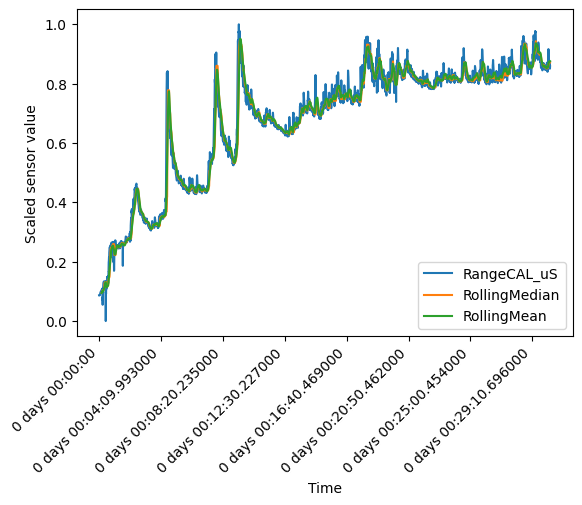

In [20]:
df1_2 = calculateRollingAndDelta(df1_2)
df1_2[['RangeCAL_uS', 'RollingMedian', 'RollingMean','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='Scaled sensor value', rot=45)

## Labeling and splitting the dataset
Here we copy the useful data to a separate dataframe and label it using thresholds. Sadly we had to make assumptions during this process as the data we have available is insufficient.
The labeled data is then visualized and split in training and test datasets.

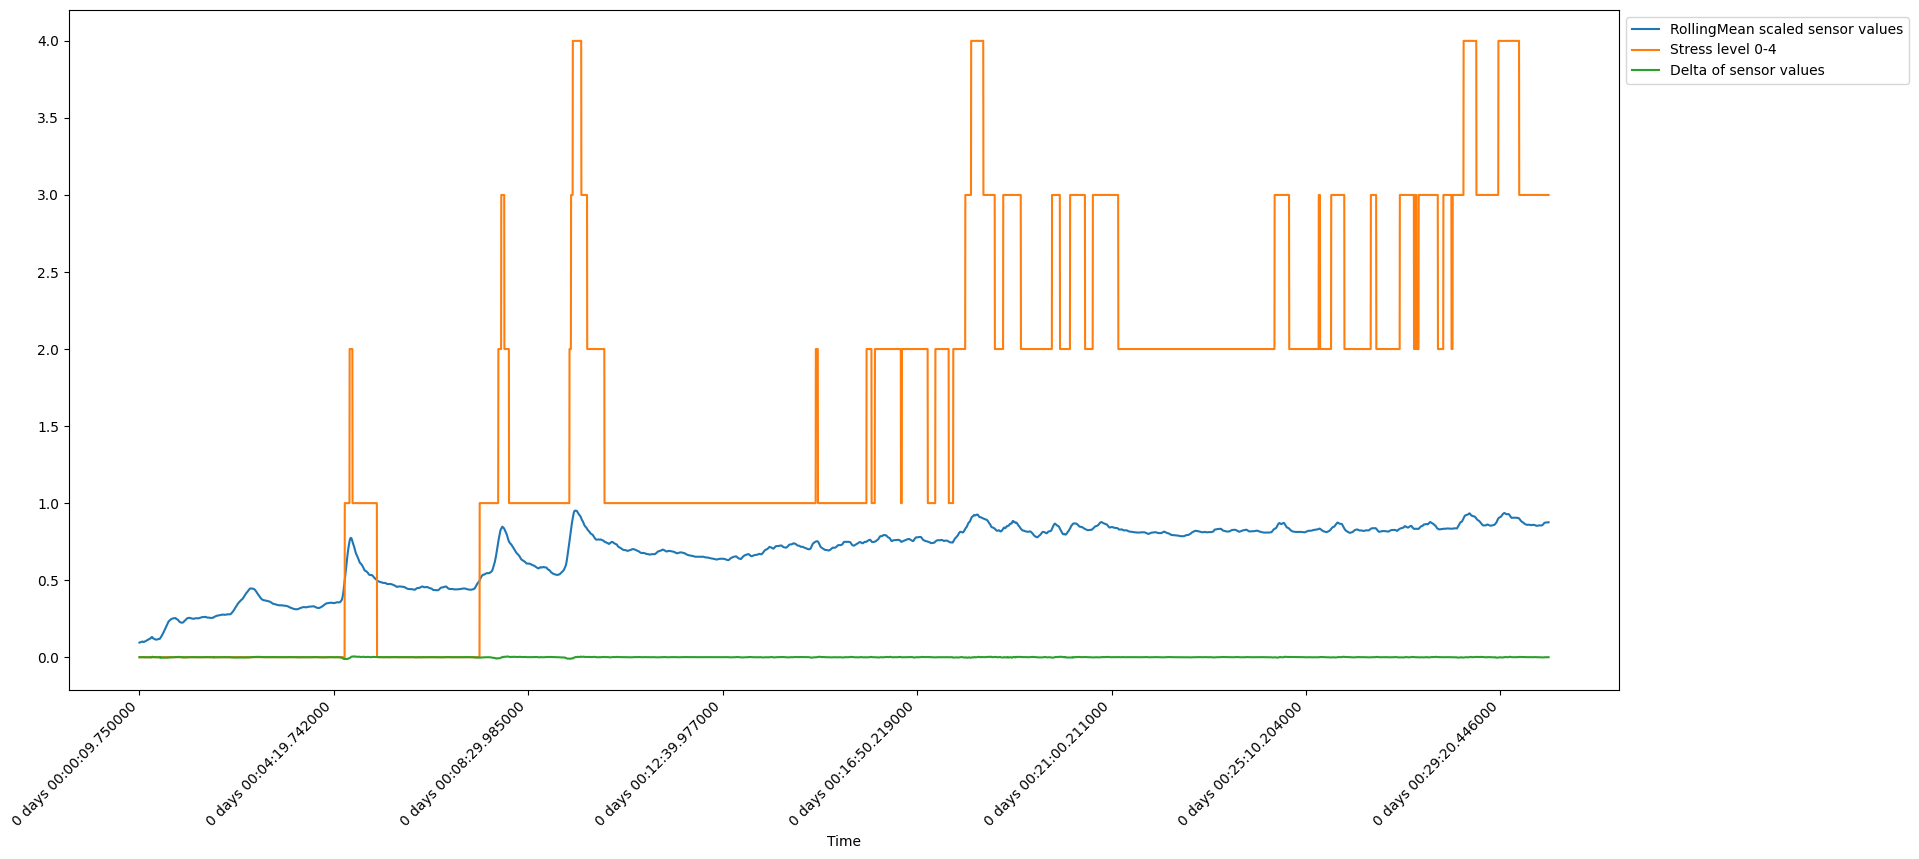

In [21]:
from sklearn.model_selection import train_test_split
stress_level = df1_2[['RollingMean', 'deltaMean', 'timestamp']].copy().dropna()

for index, row in stress_level.iterrows():
    if (row[0] > 0.2):
        stress_level.loc[index, 'stressLevel'] = 0
    if (row[0] > 0.4):
        stress_level.loc[index, 'stressLevel'] = 1
    if (row[0] > 0.6):
        stress_level.loc[index, 'stressLevel'] = 2
    if (row[0] > 0.8):
        stress_level.loc[index, 'stressLevel'] = 3
    if (row[0] > 0.9):
        stress_level.loc[index, 'stressLevel'] = 4


stress_level['stressLevel'] = stress_level['stressLevel'].fillna(0)
stress_level['weighted'] = (stress_level['stressLevel'] * stress_level['RollingMean']).round(0)

stress_level[['RollingMean', 'weighted', 'deltaMean', 'timestamp']].plot(x='timestamp', xlabel='Time', rot=45, figsize=[20, 10])
plt.legend(['RollingMean scaled sensor values','Stress level 0-4','Delta of sensor values'],bbox_to_anchor=(1.0, 1.0))
model_data = stress_level[['weighted']]

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(stress_level[['RollingMean', 'deltaMean']], model_data, test_size=0.25)


# Model training

## IsolationForest
Unused now, as this can be used to detect anomalies but not useful for the assignment of stress levels as intended in our use case.


In [22]:
# from sklearn.ensemble import IsolationForest

# IF = IsolationForest(random_state=0, contamination=0.05, n_estimators=200, max_samples=0.7)
# model_data = anomaly_detection_df[['deltaMean']]
# IF.fit(model_data)

# anomaly_detection_df['scores']=IF.decision_function(model_data)
# anomaly_detection_df['anomaly']=IF.predict(model_data)

# anomaly=anomaly_detection_df.loc[anomaly_detection_df['anomaly']==-1]
# anomaly_index=list(anomaly.index)

# print(anomaly)
# # print(anomaly_index)

# anomaly_detection_df[['anomaly', 'RollingMean','deltaMean']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45)

## DecisionTree
One of the simpler models, with a surprising accuracy. Here it is trained on the data and scored on accuracy.

In [23]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

# comment these out to verify other datasets
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=2)
tree_clf.fit(X_train_data,y_train_data)

# tree.plot_tree(tree_clf);
y_pred = tree_clf.predict(X_test_data)
accuracy_score(y_test_data, y_pred)

0.9536679536679536

### Result plot
Here we plot the results of the models accuracy scoring to visualize if there are any consistent errors.

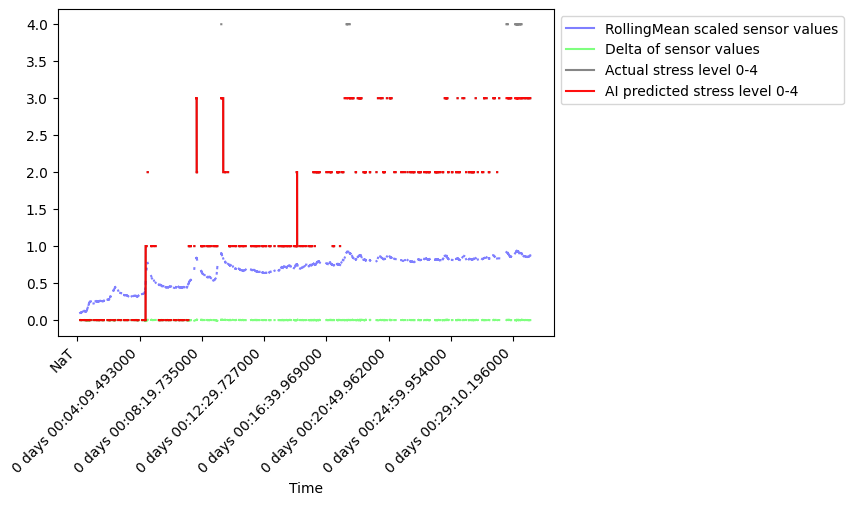

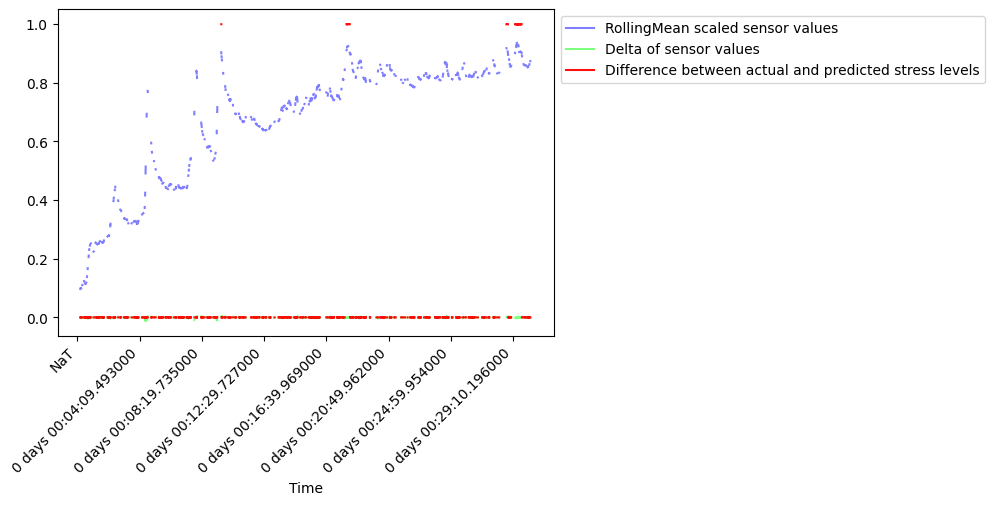

In [24]:
resultPlot = X_test_data.copy()
resultPlot['result']= y_pred.copy()
resultPlot['expected']=y_test_data.copy()

resultPlot = resultPlot.sort_index()
resultPlot_ = resultPlot.copy()
for i in resultPlot.iterrows():
    resultPlot_.loc[i[0]]=i[1]
# resultPlot_ = resultPlot_.ffill() # option to make the line continuous, may look decieving if the value before a change is wrong

resultPlot_2 = resultPlot_.sort_index().reindex(pd.RangeIndex(resultPlot_.index.max() + 1))
resultPlot_2['timestamp']= stress_level['timestamp']
resultPlot_2['errorMargin'] = resultPlot_2['expected']-resultPlot_2['result']
resultPlot_2[['RollingMean','deltaMean','expected', 'result', 'timestamp']].plot(x='timestamp',xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080', 'expected':'#0f0f0f80', 'result':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Actual stress level 0-4','AI predicted stress level 0-4'],bbox_to_anchor=(1.0, 1.0))
resultPlot_2[['RollingMean','deltaMean','errorMargin','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080','errorMargin':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Difference between actual and predicted stress levels'],bbox_to_anchor=(1.0, 1.0))

## RandomForest
Here we train a RandomForest classifier model to see if there is any significant increase in accuracy compared to the decisionTree model.

In [25]:
from sklearn.ensemble import RandomForestClassifier

# comment these out to verify other datasets
forest_clf = RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_split=2, n_estimators = 50)
forest_clf.fit(X_train_data,y_train_data)

y_pred_f = forest_clf.predict(X_test_data)
accuracy_score(y_test_data, y_pred)

/tmp/ipykernel_1605/3989888119.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_clf.fit(X_train_data,y_train_data)


0.9536679536679536

### Result plot
Here we plot the results of the models accuracy scoring to visualize if there are any consistent errors.

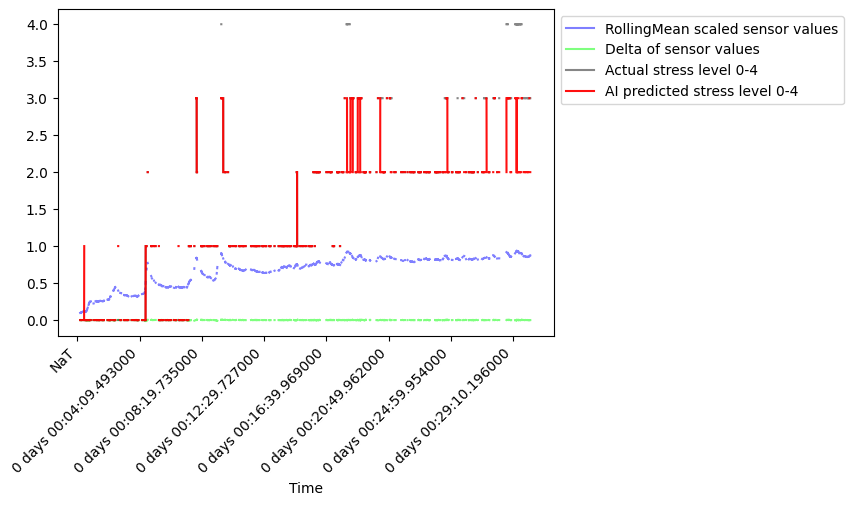

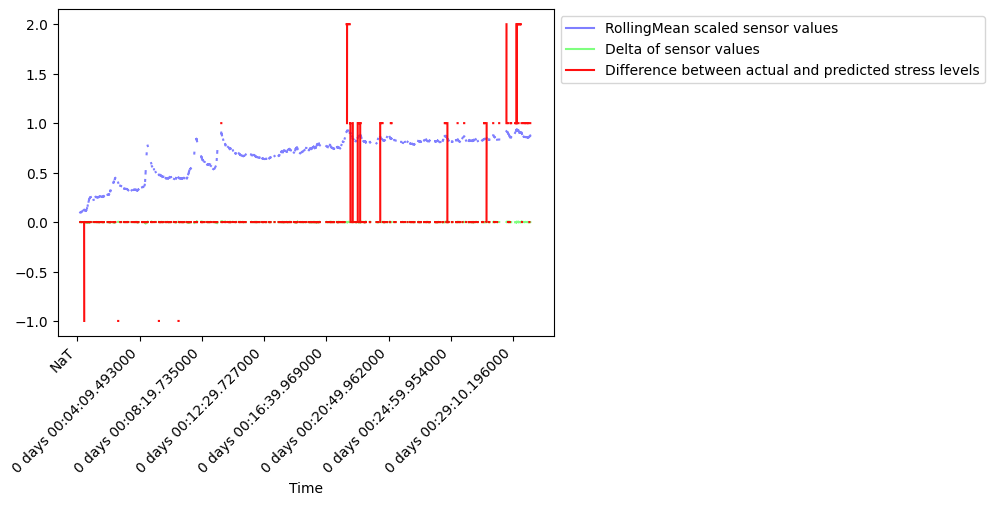

In [26]:
resultPlot = X_test_data.copy()
resultPlot['result']= y_pred_f.copy()
resultPlot['expected']=y_test_data.copy()

resultPlot = resultPlot.sort_index()
resultPlot_ = resultPlot.copy()
for i in resultPlot.iterrows():
    # print(i[0])
    resultPlot_.loc[i[0]]=i[1]
# resultPlot_ = resultPlot_.ffill()# option to make the line continuous, may look decieving if the value before a change is wrong
resultPlot_2 = resultPlot_.sort_index().reindex(pd.RangeIndex(resultPlot_.index.max() + 1))
resultPlot_2['timestamp']= stress_level['timestamp']
resultPlot_2['errorMargin'] = resultPlot_2['expected']-resultPlot_2['result']
resultPlot_2[['RollingMean','deltaMean','expected', 'result', 'timestamp']].plot(x='timestamp',xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080', 'expected':'#0f0f0f80', 'result':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Actual stress level 0-4','AI predicted stress level 0-4'],bbox_to_anchor=(1.0, 1.0))
resultPlot_2[['RollingMean','deltaMean','errorMargin','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080','errorMargin':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Difference between actual and predicted stress levels'],bbox_to_anchor=(1.0, 1.0))

# Realtime data processing using DeepHaven

In this part of the notebook we will explore the deepHaven library for realtime data processing in jupyter notebook. This is based on [this article](https://medium.com/@deephavendatalabs/real-time-tables-in-jupyter-finally-db057c2a4d3f).

Open the server [here](http://localhost:8080) to see the realtime output

In [27]:
from deephaven_server import Server
s = Server(port=8080)
s.start()

# Starting io.deephaven.python.server.EmbeddedServer
deephaven.cacheDir=/home/student/.cache/deephaven
deephaven.configDir=/home/student/.config/deephaven
deephaven.dataDir=/home/student/.local/share/deephaven
# io.deephaven.internal.log.LoggerFactoryServiceLoaderImpl: searching for 'io.deephaven.internal.log.LoggerFactory'...
# io.deephaven.internal.log.LoggerFactoryServiceLoaderImpl: found 'io.deephaven.internal.log.LoggerFactorySlf4j'
Server started on port 8080


In [28]:
from deephaven import DynamicTableWriter
import deephaven.dtypes as dht# in our example, we want to keep the text of tweet and the number of occurence of 5 keywords in this text
twitter_table_col_definitions = {"index": dht.int32, "timestamp": dht.DateTime, "RangeCAL_uS": dht.float64 ,"RollingMean": dht.float64, "deltaMean": dht.float64}
twitter_table_writer = DynamicTableWriter(twitter_table_col_definitions)
tweet_table = twitter_table_writer.table

In [29]:
import threading
from deephaven.time import now, upper_bin
from deephaven import pandas as dhpd
import time

NANOSEC_BIN = 250_000_000   # use 0.25 secs interval to get data
time_prev = 0
tweet_table = twitter_table_writer.table

print('hello world')

def get_tweets(index_):
    """
    Method to get tweets
    """
    
    value = df1_2['RangeCAL_uS'].loc[df1_2.index[index_]]
    print(value)
    df1_2.drop(index=2)
    df1_2.reset_index()
    return value

def write_live_data():
    """
    The function to write twitter data to a table
    """

    print('hello Thread')
    # df1_2['timestamp'] = pd.to_datetime(df1_2['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    # while(2 in df1_2.index):
    for i in range(df1_2.shape[0]):
        print('in Thread')
        # print(time_prev)
        # print(now())
        time_ = now()
        timestamp = upper_bin(time_, NANOSEC_BIN) # rounding the timestamps?

        # timestamp=df1_2.loc[df1_2.index[i],'timestamp']
        RangeCAL_uS = get_tweets(i)
        # do data processing here

        # try:
        data_frame = dhpd.to_pandas(tweet_table)
        
        # print(data_frame)
        data_frame = calculateRollingAndDelta(data_frame)
        
        dataTemp = data_frame.fillna(0)
            # print(tree_clf.predict(dataTemp))
        try:
            RollingMean = dataTemp['RollingMean'].loc[dataTemp.index[i]]
            deltaMean = dataTemp['deltaMean'].loc[dataTemp.index[i]]
            twitter_table_writer.write_row(i, timestamp, RangeCAL_uS, RollingMean, deltaMean)# Run the thread that writes tweets to the table
        except:
            print("error")
        # if(RollingMean.any()):
        #     print(RollingMean[2])
        time.sleep(0.25) # delay to prevent crashing I hope
        global stop_threads
        if stop_threads:
            print('killed Thread')
            break
    print('goodbye Thread')

    # get the data as long as there is any
stop_threads=False
thread = threading.Thread(target=write_live_data)
thread.start()
# thread.join()
# print(len(df1_2))
# time.sleep(10)
print('goodbye world')

hello world
hello Threadgoodbye world

in Thread
0.08677456897068803
error
in Thread
0.08682206462967577
error
in Thread
0.08696455160664006
error
in Thread
0.08777197780943165
error
in Thread
0.08705954292461554
error
in Thread
0.08729702121955424
error
in Thread
0.0872495255605665
error
in Thread
0.0872495255605665
error
in Thread
0.08729702121955424
error
in Thread
0.08734451687854199
error
in Thread
0.08734451687854199
error
in Thread
0.08786696912740713
error
in Thread
0.08848441269424882
error
in Thread
0.08848441269424882
error
in Thread
0.09047923037173605
error
in Thread
0.09138164789250419
error
in Thread
0.09233156107226008
error
in Thread
0.09337646556999142
error
in Thread
0.09446886572671052
error
in Thread
0.09532378758848985
error
in Thread
0.0961312137912825
error
in Thread
0.09674865735812421
error
in Thread
0.09722361394800161
error
in Thread
0.09760357921990352
error
in Thread
0.09803104015079425
error
in Thread
0.09845850108168391
error
in Thread
0.0988859620125746

In [30]:

time.sleep(10)

stop_threads=True # when this is called the thread(s) made above will exit

# dataTemp = df1_2[['RollingMean', 'deltaMean']]
# print(tree_clf.predict(dataTemp))

Here we have a realtime view of the data as it comes in

In [31]:
# from deephaven_ipywidgets import DeephavenWidget
# t = DeephavenWidget(tweet_table)
# display(t)

In [32]:
# from deephaven import pandas as dhpd

# data_frame = dhpd.to_pandas(tweet_table)
# data_frame

# display(DeephavenWidget(tweet_table, width=800, height=300))

In [33]:
# from deephaven import agg as agg
# from deephaven import SortDirection
# cols = []
# heat_cols = []
# for i, keyword in enumerate(KEYWORDS):
#     cols.append(f"{keyword.upper()} = KEYWORD{i+1}")
#     heat_cols.append(f"{keyword.upper()} = heatmap({keyword.upper()}, 0, 10, LEMONCHIFFON, GOLD)")
#     result = tweet_table.agg_by([agg.sum_(cols=cols)], by=["TIMESTAMP"])
# result_heat = result.format_columns(heat_cols)
# result_heat = result_heat.sort(order_by=["TIMESTAMP"], order=[SortDirection.DESCENDING])
# display(DeephavenWidget(result_heat, width=800, height=300))